<a href="https://colab.research.google.com/github/eadewusic/Time-Series-Forecasting/blob/main/LSTM_with_dropout_Eunice_Adewusi__air_quality_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle===1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username": "euniceadewusi", "key":"eef64544bac778940a260ba771f485b4"}')

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=7340db0d45e0e7e0e7ec57c159e6e5d635d93a14bbd8199e78396e145e3f50fa
  Stored in directory: /root/.cache/pip/wheels/b5/23/bd/d33cbf399584fa44fa049711892d333954a50ed4b86948109e
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [3]:
# Downloading the Assignment

!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025
!mkdir '/content/data'

!unzip -qo 'assignment-1-time-series-forecasting-may-2025.zip' -d '/content/data'

100% 839k/839k [00:00<00:00, 1.25MB/s]
100% 839k/839k [00:00<00:00, 1.25MB/s]


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os

In [5]:
# Load the datasets
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [6]:
# Print first few rows of the dataset to understand its structure
print("Training Data Overview:")
df_train.head(6)

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN
5,6,-1.442309,-1.840273,0.053790,-0.155751,-0.069353,-0.137667,2010-01-01 05:00:00,1.448138,-0.732019,-0.522096,NaN


It's obvious that pm2.5 column has missing values

In [7]:
# Training Data Info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


Here, we see that the pm2.5 column has 28,755 non-null values out of 30,676 entries, indicating there are 1,921 missing values (30676 - 28755) in this column. All other columns are complete.

In [8]:
# view dataset columns
df_train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [9]:
# Ensure 'datetime' column is in datetime format
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
df_train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
df_test.set_index('datetime', inplace=True)

In [10]:
# Statistics of dataset
df_train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


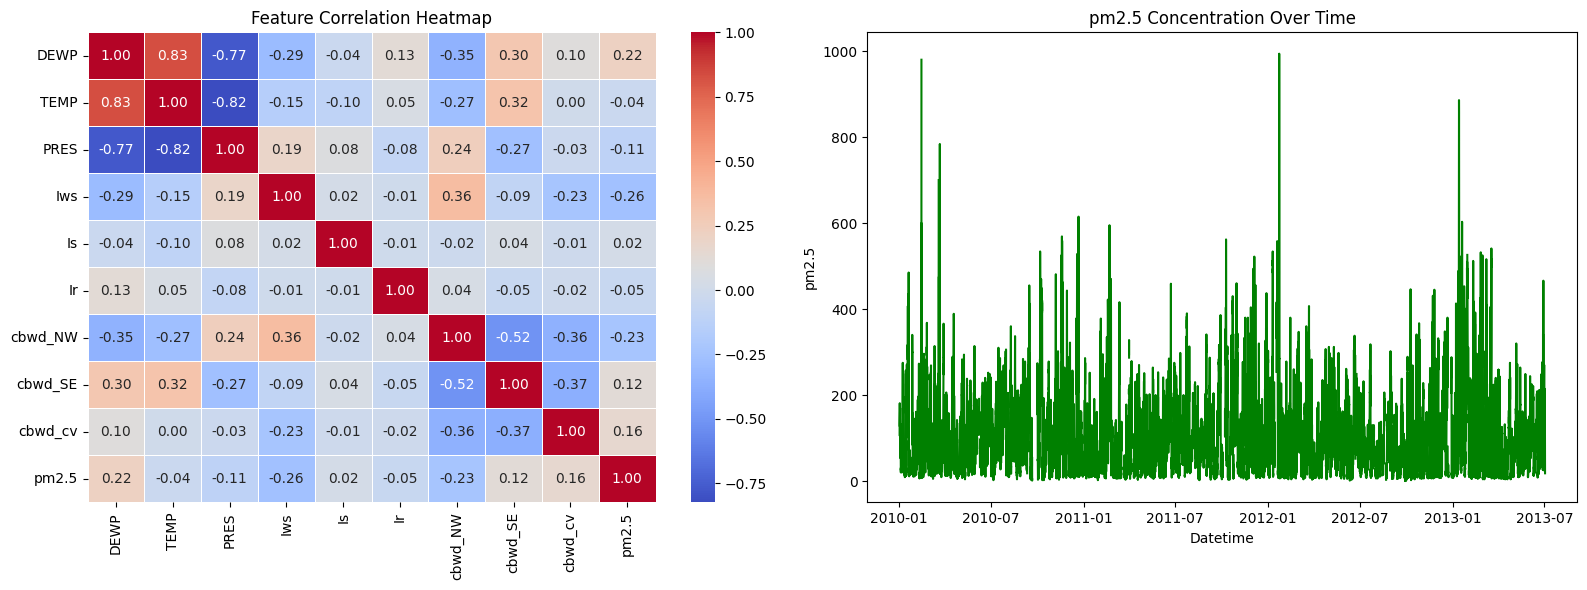

In [11]:
# visualise dataset

def plot_dataset_visuals(df_train):
    plt.figure(figsize=(16, 6))

    # Correlation HeatMap
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    corr_matrix = df_train.drop(columns=['No']).corr()  # Exclude non-numeric for correlation
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation Heatmap")

    # Line Plot pm2.5 over time
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(df_train['pm2.5'], color='green')
    plt.title("pm2.5 Concentration Over Time")
    plt.xlabel("Datetime")
    plt.ylabel("pm2.5")

    plt.tight_layout()  # Adjusts subplot params for a tight layout
    plt.show()

# Plot the dataset visuals
plot_dataset_visuals(df_train)

# Handle missing values


- I am using interpolation & forward fill methods to handle the missing values because it's the best for time series forecasting tasks. Mean imputation would break the time series structure that LSTMs need to learn from

In [12]:
# Ensure 'pm2.5' column is numeric
df_train['pm2.5'] = pd.to_numeric(df_train['pm2.5'], errors='coerce')

# Interpolate missing values and then forward-fill and backward-fill any remaining NaNs
df_train['pm2.5'] = df_train['pm2.5'].interpolate(method='linear').ffill().bfill()

print(f"After interpolation + filling: {df_train['pm2.5'].isnull().sum()}")
print("Missing values handling completed!")

After interpolation + filling: 0
Missing values handling completed!


# Seasonal Decomposition

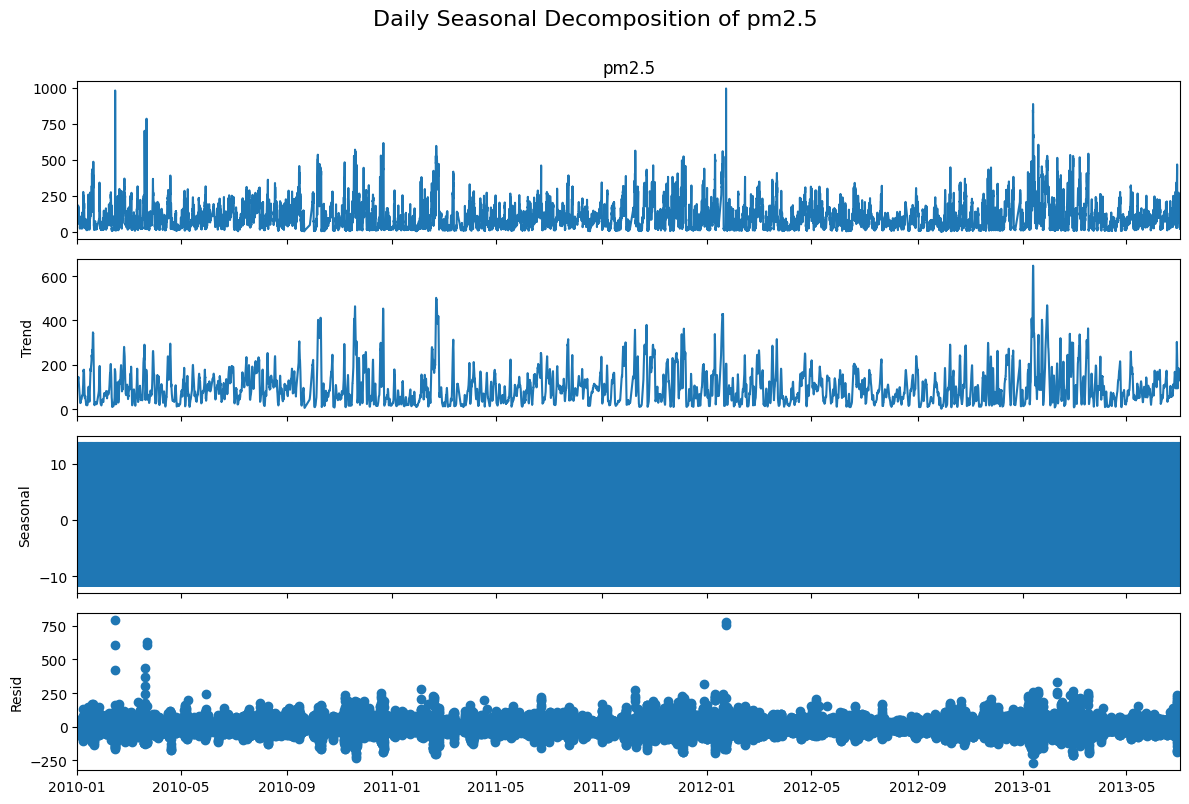

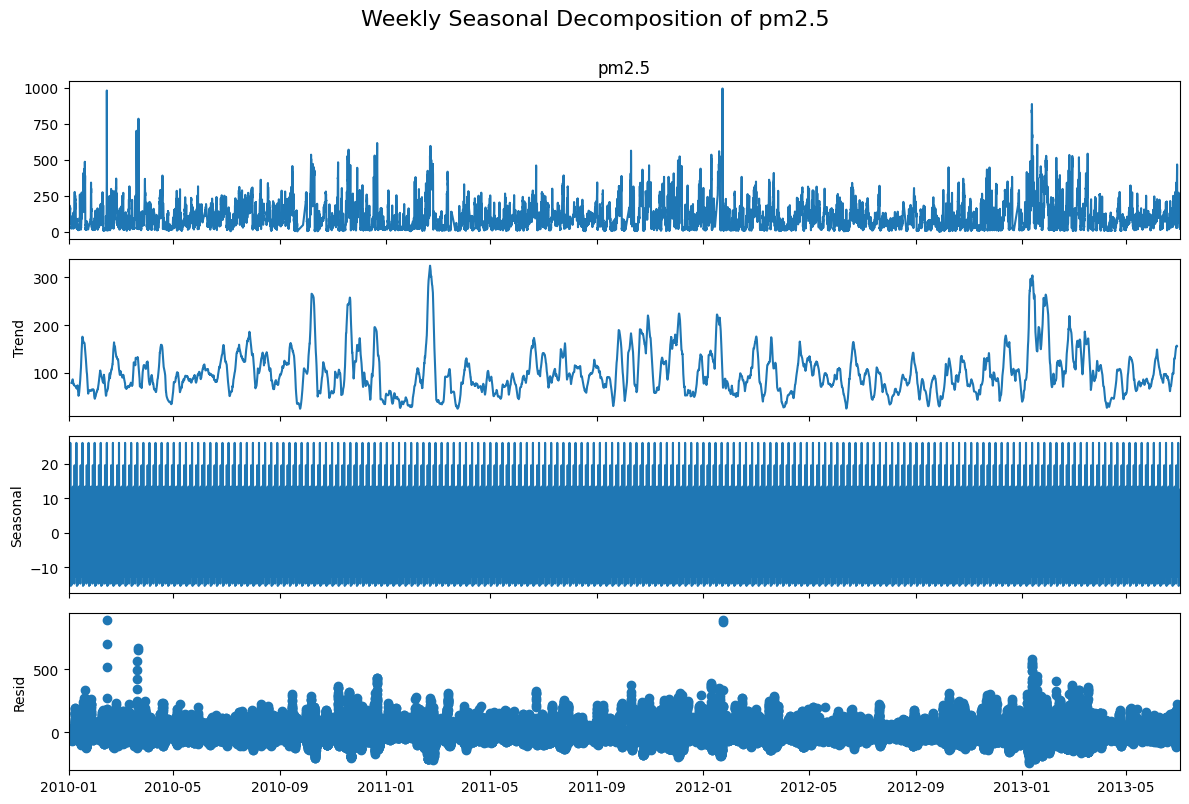

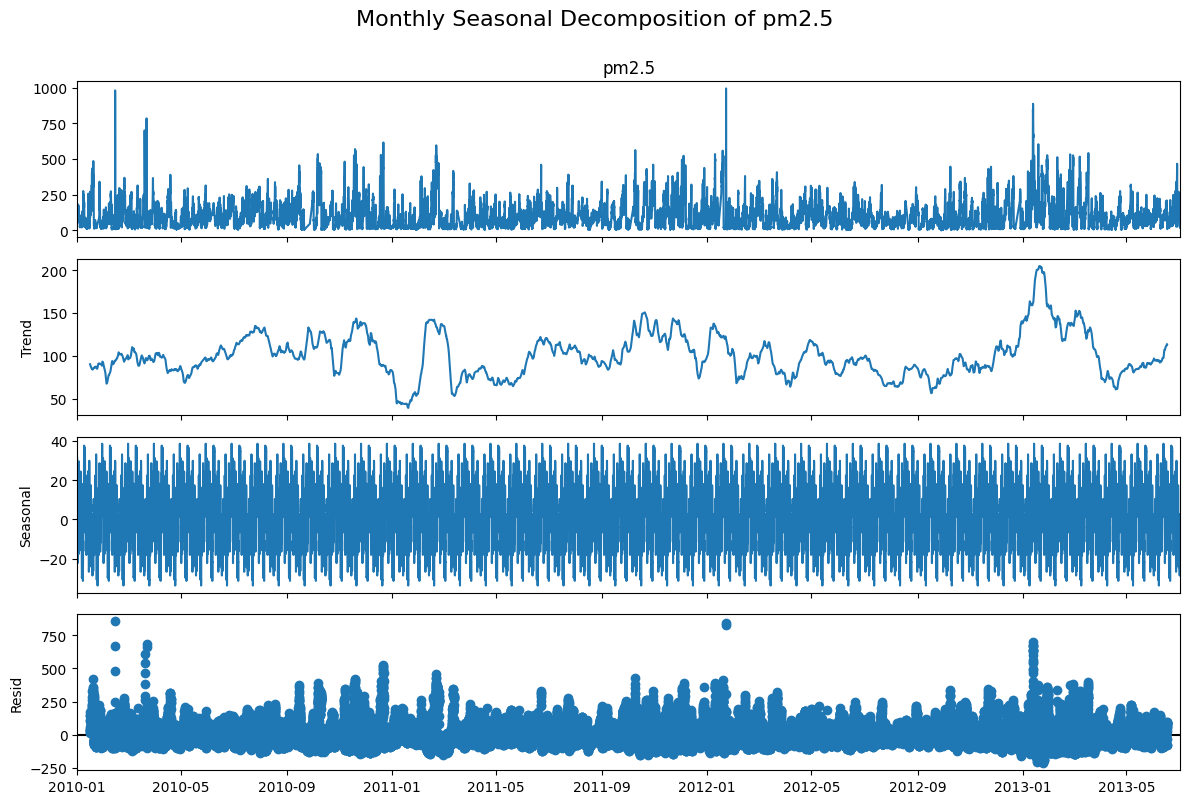

In [13]:
# Perform seasonal decomposition after ensuring no missing values, to understand underlying patterns
# 24 hours, 168 hours (7 days x 24 hours), 720 hours (30 days x 24 hours)

for period, name in [(24, 'Daily'), (168, 'Weekly'), (720, 'Monthly')]:
    result = seasonal_decompose(df_train['pm2.5'], model='additive', period=period)

    # Plot decomposition

    fig = result.plot()
    fig.set_size_inches(12, 8)

    # Set suptitle with vertical position adjusted to avoid overlap
    plt.suptitle(f'{name} Seasonal Decomposition of pm2.5', fontsize=16, y=1)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 1])  # reserve top space for title
    plt.show()

# Temporal Feature Engineering

In [14]:
# Extract components from the datetime index
for df in [df_train, df_test]:
    df['hour'] = df.index.hour  # Access hour from the index
    df['day'] = df.index.day    # Access day from the index
    df['month'] = df.index.month  # Access month from the index
    df['weekday'] = df.index.weekday  # Access weekday from the index
    df['season'] = (df.index.month % 12 + 3) // 3  # Maps months to seasons using the index

# Neural networks struggle with cyclical features like hour/month,
# cyclical encoding as sine/cosine is crucial for them to understand cycles, that hour 23 is close to hour 0
for df in [df_train, df_test]:

    # Hour cyclical encoding (24-hour cycle)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Month cyclical encoding (12-month cycle)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Day of week cyclical encoding (7-day cycle)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

    # Day of month cyclical encoding (approximate 30-day cycle)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 30)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 30)

    df['is_weekend'] = (df['weekday'] >= 5).astype(int) # Weekend indicator
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) | (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int) # Rush hours (peak pollution times)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 5)).astype(int) # Night time (lower activity)
    df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int) # Winter months (higher pollution in Beijing)

In [15]:
# Fill remaining missing values with appropriate strategies
numeric_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
categorical_cols = ['cbwd_NW', 'cbwd_SE', 'cbwd_cv']

# Define feature columns
feature_cols = numeric_cols + categorical_cols + [
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_winter'
]

print(f"Feature columns: {feature_cols}")
print(f"Number of features: {len(feature_cols)}")

Feature columns: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_winter']
Number of features: 15


# Normalization

In [16]:
# Separate features and target
X_train = df_train.drop(['pm2.5', 'No'], axis=1, errors='ignore')
y_train = df_train['pm2.5']

# Standardize features
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)

# Standardize target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

In [17]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)

In [18]:
# Train-test split for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [19]:
# Clear previous models
tf.keras.backend.clear_session()

# Bidirectional LSTM model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=False, dropout=0.3, recurrent_dropout=0.2)),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Same compilation as your Experiment 3
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 128)         │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,865 (347.13 KB)

 Trainable params: 88,865 (347.13 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Callbacks for early stopping and learning rate reduction
# increase the patience for better training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# Train the model
# increase epochs and batch size
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=64,     # Increased from 32 for more stable gradients
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
384/384 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.8502 - rmse: 0.9216 - val_loss: 0.6060 - val_rmse: 0.7785 - learning_rate: 0.0010
Epoch 2/40
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.7198 - rmse: 0.8483 - val_loss: 0.5670 - val_rmse: 0.7530 - learning_rate: 0.0010
Epoch 3/40
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.6629 - rmse: 0.8141 - val_loss: 0.5371 - val_rmse: 0.7329 - learning_rate: 0.0010
Epoch 4/40
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.6335 - rmse: 0.7956 - val_loss: 0.5162 - val_rmse: 0.7184 - learning_rate: 0.0010
Epoch 5/40
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.6516 - rmse: 0.8069 - val_loss: 0.5028 - val_rmse: 0.7091 - learning_rate: 0.0010
Epoch 6/40
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.6138 - rmse: 0.7834 - val_loss: 0.4981 - val_rmse: 0.7058 - learning_rate: 0.0010
Epoch 7/40
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6364 - rmse: 0.7975 - val_loss: 0.4742 - val_rmse: 0.6887 - learni

In [21]:
# Predict on full train and validation data
train_pred = model.predict(X_train_scaled)
train_pred_inv = scaler_y.inverse_transform(train_pred)
y_train_inv = scaler_y.inverse_transform(y_train_scaled)

val_pred = model.predict(X_val)
y_val_inv = scaler_y.inverse_transform(y_val)
val_pred_inv = scaler_y.inverse_transform(val_pred)

# Calculate RMSE
train_rmse = np.sqrt(np.mean((y_train_inv - train_pred_inv) ** 2))
val_rmse = np.sqrt(np.mean((y_val_inv - val_pred_inv) ** 2))

print(f'Final Train RMSE: {train_rmse:.2f}')
print(f'Final Validation RMSE: {val_rmse:.2f}')

959/959 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Final Train RMSE: 56.19
Final Validation RMSE: 57.48


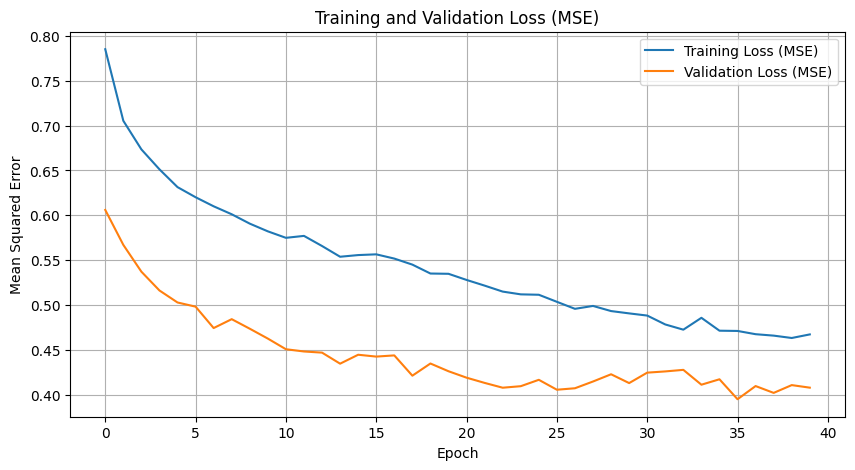

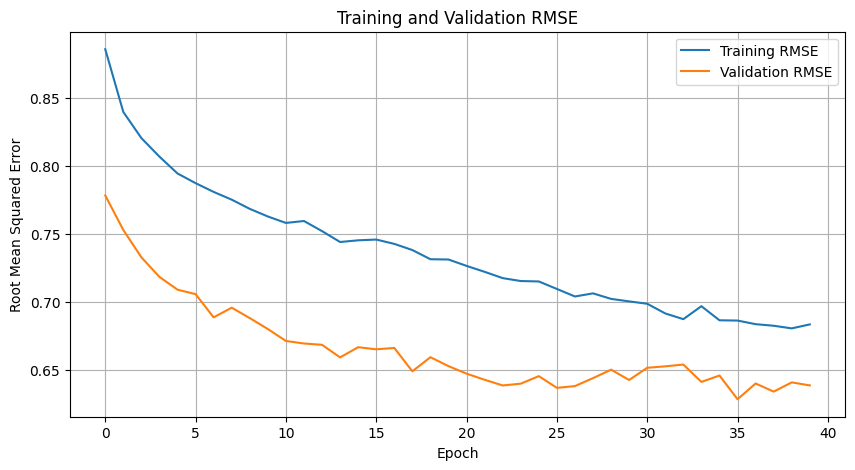

In [22]:
# Plot MSE loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot RMSE over epochs (since you tracked it with metrics=['rmse'])
plt.figure(figsize=(10, 5))
plt.plot(history.history['rmse'], label='Training RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Prepare test data
X_test = df_test.drop(['No', 'pm2.5'], axis=1, errors='ignore')
X_test_scaled = scaler_x.transform(X_test)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test_scaled)

# Convert back to original scale
predictions = scaler_y.inverse_transform(predictions)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

predictions = np.clip(predictions, 0, np.max(predictions))  # Ensure no negative values

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(df_test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Create directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Save the file in CSV format for submission on Kaggle
submission.to_csv('outputs/sample_submission.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [24]:
pip install --upgrade kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8


In [25]:
""" Submitting to Kaggle """

# Create submission CSV file with predictions

# Submit to Kaggle
!kaggle competitions submit -c assignment-1-time-series-forecasting-may-2025 -f outputs/sample_submission.csv -m "Test Submission"

100% 294k/294k [00:01<00:00, 257kB/s]
Successfully submitted to Assignment 1- Time Series Forecasting May 2025